Install torchvision and torch needed for this image classification

In [67]:
!pip install torchvision torch


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\x2421\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [68]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import random
import copy

Define a transform that can resize image to (256, 256) and retype to tensor

In [69]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resize = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
augmented = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.RandomHorizontalFlip(0.5), transforms.RandomRotation(45)])

In [70]:
type = os.listdir("dataImage")
for i in range(len(type)):
    type[i] = "./dataImage/" + type[i] + "/"
type

['./dataImage/Acer/',
 './dataImage/Alnus incana/',
 './dataImage/Betula pubescens/',
 './dataImage/Fagus silvatica/',
 './dataImage/Populus/',
 './dataImage/Populus tremula/',
 './dataImage/Quercus/',
 "./dataImage/Salix alba 'Sericea'/",
 './dataImage/Salix aurita/',
 './dataImage/Salix sinerea/',
 './dataImage/Sorbus aucuparia/',
 './dataImage/Sorbus intermedia/',
 './dataImage/Tilia/',
 './dataImage/Ulmus carpinifolia/',
 './dataImage/Ulmus glabra/']

Define a class to store train and validation dataset

In [71]:
class Dataset(Dataset):
    def __init__(self, transform = None, train = True, train_rate = 0.7):
        # get the file path and name
        type = os.listdir("dataImage")
        for i in range(len(type)):
            type[i] = "./dataImage/" + type[i] + "/"
        
        plant_files = []
        number_of_sample = 0
        for i in range(len(type)):
            leaves_category = [os.path.join(type[i], file) for file in os.listdir(type[i]) if file.endswith(".jpg")]
            sorted(leaves_category, key=lambda x : random.random())
            plant_files.append(leaves_category)
            number_of_sample += len(leaves_category)
            
        # store all files
        self.all_files = [None] * number_of_sample
        self.Y = torch.zeros([number_of_sample]).type(torch.LongTensor)
        for i in range(len(type)):
            self.all_files[i::15] = plant_files[i]
            self.Y[i::15] = i
        self.transforms = transform
        
        if train:
            self.all_files = self.all_files[0 : int(number_of_sample*0.7)]
            self.Y = self.Y[0 : int(number_of_sample)]
            self.len = len(self.all_files)    
        else:
            self.all_files = self.all_files[int(number_of_sample*0.7):]
            self.Y = self.Y[int(number_of_sample*0.7):]
            self.len = len(self.all_files)
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index): 
        image = Image.open(self.all_files[index])
        y = self.Y[index]
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, y
    
    def __getImage__(self, index):
        image = Image.open(self.all_files[index])
        trans = transforms.Compose([transforms.Resize((224, 224))])
        image = trans(image)
        label = self.Y[index]
        return image, label



In [72]:
dataset_train = Dataset(transform=augmented, train=True)
dataset_val = Dataset(transform=augmented, train=False)

In [73]:
print(dataset_train.__len__())
print(dataset_val.__len__())

787
338


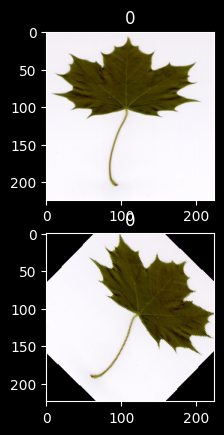

In [74]:
plt.Figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.title(dataset_train.__getImage__(0)[1].item())
plt.imshow(dataset_train.__getImage__(0)[0])
plt.subplot(2, 1, 2)
plt.title(dataset_train.__getImage__(0)[1].item())
img = Image.open(dataset_train.all_files[0])
plt.imshow((dataset_train.__getitem__(0)[0]).permute(1, 2, 0))

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(32, momentum=0.1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop1 = nn.Dropout2d(0.3)
        
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(64, momentum=0.1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop2 = nn.Dropout2d(0.3)
        
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(64, momentum=0.1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop3 = nn.Dropout2d(0.3)
        
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(128, momentum=0.1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop4 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(128 * 10 * 10, 15)
        
        
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.drop1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop3(x)
        
        x = self.cnn4(x)
        x = torch.relu(x)
        x = self.maxpool4(x)
        x = self.drop4(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x
        

In [76]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=4):
    
    N_test = len(dataset_val)
    accuracy_list = []
    loss_list = []
    for epoch in range(n_epochs):
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.data)
        
        correct = 0
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / 338
        print(accuracy)
        accuracy_list.append(accuracy)
    
    return accuracy_list, loss_list

In [77]:
#model = CNN()
#model
model = models.resnet18((32, 224, 224, 3))
for param in model.parameters():
    param.requires_grad=False

model.fc = nn.Linear(512, 15)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size=32)

In [79]:
accuracy_list_normal, loss_list_normal = train_model(model, train_loader, validation_loader, optimizer, 10)

0.5384615384615384
0.8846153846153846
0.893491124260355
0.9142011834319527
0.893491124260355
0.9053254437869822
0.8846153846153846
0.9112426035502958
0.9053254437869822
0.9378698224852071


<function matplotlib.pyplot.show(close=None, block=None)>

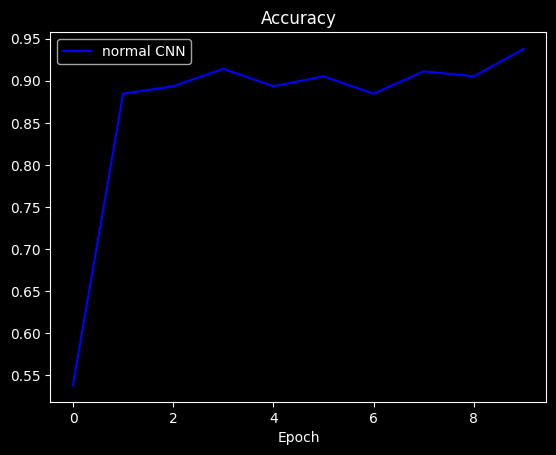

In [80]:
plt.plot(accuracy_list_normal, 'b', label = 'normal CNN')
plt.xlabel("Epoch")
plt.title('Accuracy')
plt.legend()
plt.show

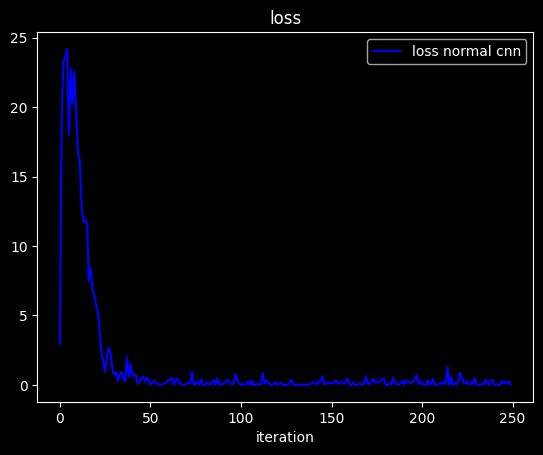

In [81]:
plt.plot(loss_list_normal, 'b', label='loss normal cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()